In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = sns.load_dataset('titanic')

# Fill missing values
modes = df.mode().iloc[0]
df = df.fillna(modes)

# Log transform fare into more normal distribution
df['log_fare'] = np.log(df['fare']+1)

# Drop columns
drop_cols = ['fare', 'embark_town', 'alive', 'who', 'class']
df = df.drop(drop_cols, axis=1)

# Convert bools to ints
bool_cols = ['adult_male', 'alone']
df[bool_cols] = df[bool_cols].astype(int)

# dummify categorical columns
dummy_cols = ['sex', 'embarked', 'pclass', 'deck']
df = pd.get_dummies(df, columns=dummy_cols)

# Normalize columns
df = df / df.max(axis=0)

# Add interceopt
df['intercept'] = 1

display(df.sample(4))
print(df.info())

,survived,age,sibsp,parch,adult_male,alone,log_fare,sex_female,sex_male,embarked_C,...,pclass_2,pclass_3,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,intercept
706,1.0,0.56250,0.000,0.000000,0.0,1.0,0.428486,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
635,1.0,0.35000,0.000,0.000000,0.0,1.0,0.422864,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
10,1.0,0.05000,0.125,0.166667,0.0,0.0,0.460439,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
814,0.0,0.38125,0.000,0.000000,1.0,1.0,0.352955,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    float64
 1   age         891 non-null    float64
 2   sibsp       891 non-null    float64
 3   parch       891 non-null    float64
 4   adult_male  891 non-null    float64
 5   alone       891 non-null    float64
 6   log_fare    891 non-null    float64
 7   sex_female  891 non-null    float64
 8   sex_male    891 non-null    float64
 9   embarked_C  891 non-null    float64
 10  embarked_Q  891 non-null    float64
 11  embarked_S  891 non-null    float64
 12  pclass_1    891 non-null    float64
 13  pclass_2    891 non-null    float64
 14  pclass_3    891 non-null    float64
 15  deck_A      891 non-null    float64
 16  deck_B      891 non-null    float64
 17  deck_C      891 non-null    float64
 18  deck_D      891 non-null    float64
 19  deck_E      891 non-null    f

# Logistic Regression Model

In [3]:
import torch

torch.set_printoptions(linewidth=140, edgeitems=6)

Accuracy: 86.03%


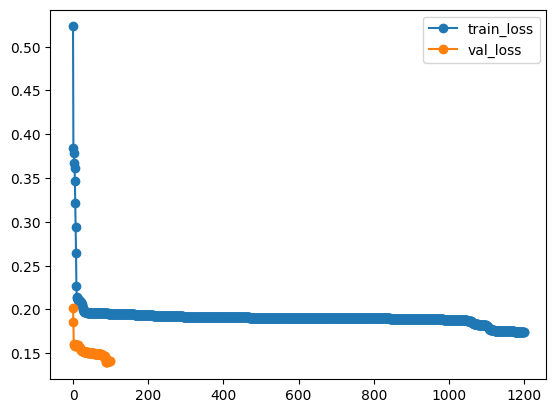

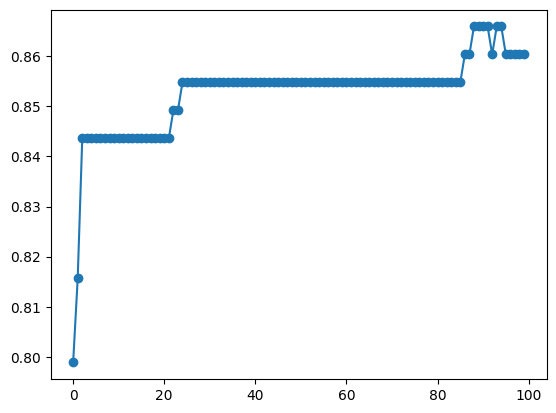

In [12]:
y = torch.tensor(df['survived'].values, dtype=torch.float32)
X = torch.tensor(df.drop('survived', axis=1).values, dtype=torch.float32)
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

num_features = X.shape[1]
epochs = 100
bs = 64
lr = 1e2

coeffs = torch.rand(num_features) - 0.5
coeffs.requires_grad_()

train_loss = []
val_loss = []
val_acc = []
for epoch in range(epochs):
    inds = torch.randperm(len(x_train))
    batches = [(x_train[inds][i:i+bs], y_train[inds][i:i+bs]) for i in range(0, len(x_train), bs)]
    for batch in batches:
        x_batch, y_batch = batch
        y_preds = torch.nn.functional.sigmoid((x_train * coeffs).sum(dim=1))
        loss = torch.abs(y_train - y_preds).mean()
        loss.backward()
        with torch.no_grad():
            coeffs -= coeffs.grad * lr
            coeffs.grad.zero_()
        train_loss.append(loss.item())
    with torch.no_grad():
        y_preds = torch.nn.functional.sigmoid((x_test * coeffs).sum(dim=1))
        val_loss.append(torch.abs(y_test-y_preds).mean().item())
        val_acc.append(((y_preds > 0.5).float() == y_test).float().mean().item())
print(f'Accuracy: {val_acc[-1]:0.2%}')

plt.plot(train_loss, marker='o', label='train_loss')
plt.plot(val_loss, marker='o', label='val_loss')
plt.legend()
plt.show()

plt.plot(val_acc, marker='o', label='val_acc')
plt.show()

Accuracy: 85.47%


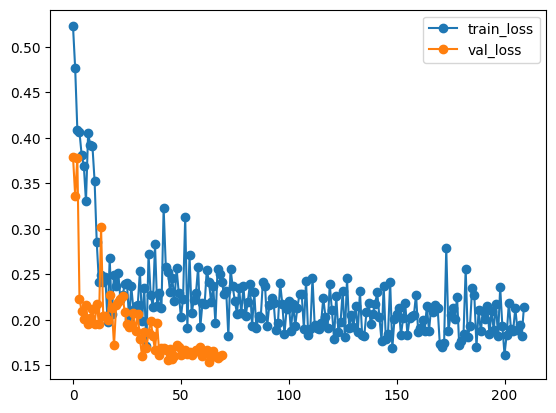

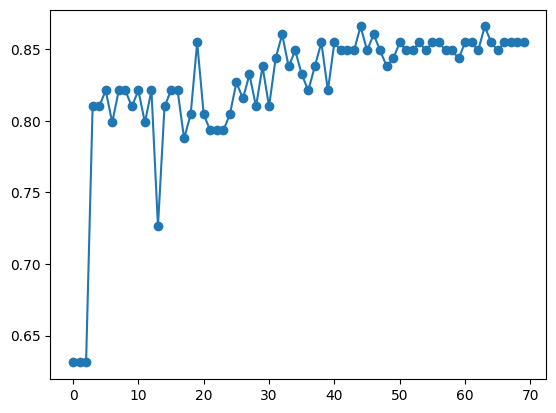

In [52]:
num_features = X.shape[1]
epochs = 70
bs = 256
lr = 10
dropout = 0.3
reg = 1e-4

model = torch.nn.Sequential(
    torch.nn.Linear(num_features, 30),
    torch.nn.ReLU(),
    torch.nn.Dropout(dropout),
    torch.nn.Linear(30, 15),
    torch.nn.ReLU(),
    torch.nn.Dropout(dropout),
    torch.nn.Linear(15, 1),
    torch.nn.Sigmoid()
)

train_loss = []
val_loss = []
val_acc = []
for epoch in range(epochs):
    inds = torch.randperm(len(x_train))
    batches = [(x_train[inds][i:i+bs], y_train[inds][i:i+bs]) for i in range(0, len(x_train), bs)]
    for batch in batches:
        x_batch, y_batch = batch
        y_preds = model(x_batch).squeeze()
        loss = torch.abs(y_batch - y_preds).mean() + torch.cat([t.abs().view(-1) for t in model.parameters()]).sum() * reg
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                param -= param.grad * lr
                param.grad.zero_()
        train_loss.append(loss.item())
    with torch.no_grad():
        y_preds = model(x_test).squeeze()
        val_loss.append(torch.abs(y_test-y_preds).mean().item() + torch.cat([t.abs().view(-1) for t in model.parameters()]).sum() * reg)
        val_acc.append(((y_preds > 0.5).float() == y_test).float().mean().item())
print(f'Accuracy: {val_acc[-1]:0.2%}')

plt.plot(train_loss, marker='o', label='train_loss')
plt.plot(val_loss, marker='o', label='val_loss')
plt.legend()
plt.show()

plt.plot(val_acc, marker='o', label='val_acc')
plt.show()